# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import detect_simpsons_paradox as dsp
import fairsim as spdata
from fairsim import sp_plot
import itertools as itert

/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,15.590881,8.523592,8.365164,9.046515,7.179804,2.738268,A0,B0,C4
1,4.450999,4.417465,8.105221,9.986472,5.953426,6.496119,A1,B0,C3
2,8.798203,7.620384,11.245195,11.455951,3.204106,5.540127,A2,B1,C4
3,4.516936,4.540947,12.190197,11.255918,13.272333,12.309657,A1,B1,C2
4,14.170029,9.501103,13.014375,10.241709,6.966316,5.410556,A0,B1,C3


We'll also plot them in the dimensions where we added SP

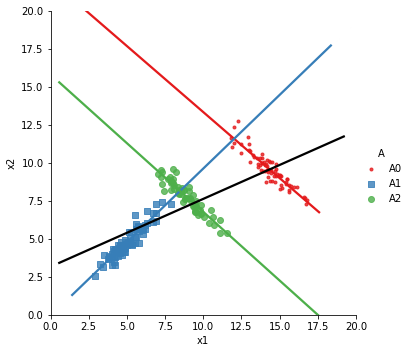

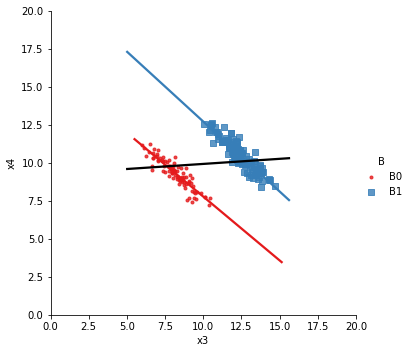

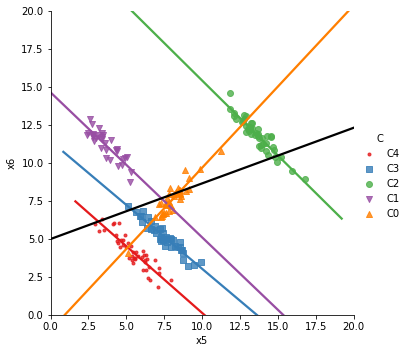

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_result = dsp.mark_designed_rows(dsp.detect_simpsons_paradox(many_sp_df_diff),sp_design_list)
many_sp_df_diff_result.head() # we only need to see a little

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed
0,0.794777,x1,x2,-0.919089,A,A0,True
1,-0.094391,x1,x3,0.018170,A,A0,False
2,-0.025108,x2,x3,0.018576,A,A0,False
3,0.044610,x2,x4,-0.115110,A,A0,False
4,-0.094391,x1,x3,0.156472,A,A1,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_result['designed'].value_counts()

False    38
True      8
Name: designed, dtype: int64

We can look at the correlatiton coefficients first

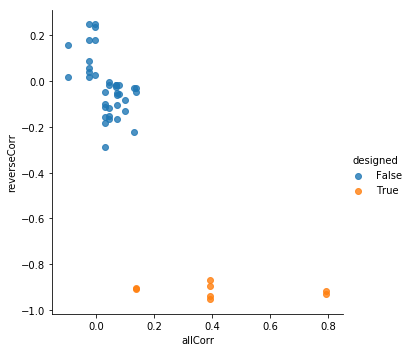

In [6]:

sns.lmplot('allCorr','reverseCorr',data=many_sp_df_diff_result, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_result.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,38.0,0.038417,0.057467,-0.094391,-0.002181,0.044610,0.072898,0.137316
True,8.0,0.429820,0.251496,0.137316,0.329525,0.393594,0.493890,0.794777


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module that compute the slopes of each subgroup trend and the overall trend lines. 

In [8]:
results_df_slopes = dsp.add_slope_cols(many_sp_df_diff, many_sp_df_diff_result)

results_df_slopes

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212
2,-0.094391,x1,x3,0.018170,A,A0,False,0.039353,-0.054620
3,-0.094391,x1,x3,0.156472,A,A1,False,0.331816,-0.054620
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878
7,-0.025108,x2,x3,0.056532,B,B1,False,0.025694,-0.025878
8,-0.025108,x2,x3,0.089100,C,C1,False,0.095430,-0.025878
9,-0.025108,x2,x3,0.038915,C,C4,False,0.040718,-0.025878


For ranking, looking at the angle between is most interesting

In [9]:

results_df_slopes = dsp.add_angle_col(results_df_slopes)
results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212,65.025511
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212,66.142007
2,-0.094391,x1,x3,0.018170,A,A0,False,0.039353,-0.054620,-5.379994
3,-0.094391,x1,x3,0.156472,A,A1,False,0.331816,-0.054620,-21.483046
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887


Then, to rank, we can sort by various values

In [10]:
results_df_slopes.sort_values('angle',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212,66.142007
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212,65.025511
24,0.393594,x5,x6,-0.936931,C,C2,True,-0.986515,0.365956,64.711471
23,0.393594,x5,x6,-0.869606,C,C1,True,-0.953632,0.365956,63.740797
26,0.393594,x5,x6,-0.897041,C,C4,True,-0.877569,0.365956,61.369593
25,0.393594,x5,x6,-0.950810,C,C3,True,-0.840324,0.365956,60.141547
14,0.100822,x4,x5,-0.131703,B,B0,False,-0.492319,0.316133,43.755357
15,0.100822,x4,x5,-0.083368,C,C2,False,-0.064187,0.316133,21.216069
12,0.130560,x3,x6,-0.028971,B,B0,False,-0.099099,0.185660,16.177251
13,0.130560,x3,x6,-0.221504,C,C1,False,-0.080699,0.185660,15.131457


In [11]:
results_df_slopes.sort_values('allCorr',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212,65.025511
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212,66.142007
25,0.393594,x5,x6,-0.950810,C,C3,True,-0.840324,0.365956,60.141547
24,0.393594,x5,x6,-0.936931,C,C2,True,-0.986515,0.365956,64.711471
23,0.393594,x5,x6,-0.869606,C,C1,True,-0.953632,0.365956,63.740797
26,0.393594,x5,x6,-0.897041,C,C4,True,-0.877569,0.365956,61.369593
13,0.130560,x3,x6,-0.221504,C,C1,False,-0.080699,0.185660,15.131457
12,0.130560,x3,x6,-0.028971,B,B0,False,-0.099099,0.185660,16.177251
14,0.100822,x4,x5,-0.131703,B,B0,False,-0.492319,0.316133,43.755357
15,0.100822,x4,x5,-0.083368,C,C2,False,-0.064187,0.316133,21.216069


We can also compare how each occurence ranks by different variables. 

In [12]:
results_df_slopes.rank(numeric_only=True).head(10)

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
0,26.5,4.0,24.5,5.0,26.5,26.0
1,26.5,3.0,24.5,3.0,26.5,27.0
2,1.5,16.0,11.0,18.0,1.5,5.0
3,1.5,22.0,11.0,25.0,1.5,3.0
4,5.5,17.0,11.0,20.0,5.5,6.0
5,5.5,23.0,11.0,26.0,5.5,2.0
6,5.5,27.0,11.0,27.0,5.5,1.0
7,5.5,20.0,11.0,17.0,5.5,10.0
8,5.5,21.0,11.0,24.0,5.5,4.0
9,5.5,19.0,11.0,19.0,5.5,7.0


We can look at the spearman correlation of the various features.  THis is equic

In [13]:
results_df_slopes.corr(method='spearman')

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
allCorr,1.000000,-0.865332,0.727720,-0.913731,0.961395,0.957507
reverseCorr,-0.865332,1.000000,-0.720577,0.948718,-0.849918,-0.902320
designed,0.727720,-0.720577,1.000000,-0.720577,0.727720,0.720577
subgroup_slope,-0.913731,0.948718,-0.720577,1.000000,-0.892768,-0.965812
all_slope,0.961395,-0.849918,0.727720,-0.892768,1.000000,0.962439
angle,0.957507,-0.902320,0.720577,-0.965812,0.962439,1.000000


In [14]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,21.0,2.202941,16.592834,-31.088171,-3.919887,-2.810187,13.140600,43.755357
True,6.0,63.521821,2.308593,60.141547,61.962394,64.226134,64.947001,66.142007


In [15]:
results_df_slopes.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,21.0,0.023128,0.067981,-0.094391,-0.025108,-0.002181,0.079092,0.130560
True,6.0,0.527322,0.207170,0.393594,0.393594,0.393594,0.694481,0.794777


# View Ranking

For vizualization, we actually need to rank the views, where a view is defined by two attributes (to be used for x and y axes) and a colored view is defined by a triplet (attr1, attr2, groupby).

First, we'll look at the views , then different ways of ranking them. and finally ways to rank the occurences for highlighting within the view.  

The views show how many different plots of the data we would need to look at to see the SP occurences. 

In [16]:
dsp.get_SP_views(results_df_slopes)

[('x4', 'x5'),
 ('x2', 'x3'),
 ('x1', 'x6'),
 ('x4', 'x6'),
 ('x3', 'x6'),
 ('x1', 'x3'),
 ('x5', 'x6'),
 ('x1', 'x2'),
 ('x2', 'x6')]

Colored views show how many different colorings we should plot to see the SP (colring the samples by groupby attribute and adding trendlines for each color)

In [17]:
dsp.get_SP_colored_views(results_df_slopes)

[('x1', 'x3', 'A'),
 ('x2', 'x6', 'A'),
 ('x2', 'x3', 'A'),
 ('x5', 'x6', 'C'),
 ('x3', 'x6', 'C'),
 ('x4', 'x5', 'C'),
 ('x2', 'x3', 'B'),
 ('x1', 'x2', 'A'),
 ('x4', 'x5', 'B'),
 ('x2', 'x3', 'C'),
 ('x1', 'x6', 'B'),
 ('x1', 'x6', 'C'),
 ('x2', 'x6', 'C'),
 ('x3', 'x6', 'B'),
 ('x4', 'x6', 'C'),
 ('x4', 'x6', 'B')]

To rank by views we need some sort of statistic for each of them.  First we will look at the number and portion of possible occurences for each view.  That is for how many groupby attributes does a view have SP or values of the groupby attribute does a colored view have SP, numerially and as a percentage in both cases

In [18]:
view_df = dsp.count_sp_views(results_df_slopes)
view_df

,attr1,attr2,SP_subgroups
0,x1,x2,2
1,x1,x3,2
2,x1,x6,4
3,x2,x3,6
4,x2,x6,2
5,x3,x6,2
6,x4,x5,2
7,x4,x6,3
8,x5,x6,4


And we can also do this for colored views

In [19]:
colored=True

In [20]:
colored_view_df = dsp.count_sp_views(results_df_slopes,colored= True)
colored_view_df.head()

,attr1,attr2,groupbyAttr,SP_subgroups
0,x1,x2,A,2
1,x1,x3,A,2
2,x1,x6,B,1
3,x1,x6,C,3
4,x2,x3,A,3


We can further look at the portion of the possible subgroups for colored views that have SP.  The poriton for non colored views is less meaningful, so we don't offer a means to compute it. This requires botht the results and the 
koriginal data, to get the number of possible levels. 

In [21]:
colored_view_df = dsp.count_sp_views(results_df_slopes,colored= True,portions=True, data_df=many_sp_df_diff)
colored_view_df.head() 

,attr1,attr2,groupbyAttr,SP_subgroups,portions
0,x1,x2,A,2,0.666667
1,x1,x3,A,2,0.666667
2,x1,x6,B,1,0.500000
3,x1,x6,C,3,0.600000
4,x2,x3,A,3,1.000000


We can also add the number of total groupby attributes with SP per uncoloed view to a count df about either a colored or uncolored count.  We'll add it to the colored one, here

In [24]:
colored_view_df = dsp.count_sp_views(results_df_slopes,colored= True,
                                     portions=True, data_df=many_sp_df_diff,
                                     groupby_count=True)
colored_view_df.head() 

,attr1,attr2,groupbyAttr,SP_subgroups,gby_counts,portions
0,x1,x2,A,2,1,0.666667
1,x1,x3,A,2,1,0.666667
2,x1,x6,B,1,2,0.500000
3,x1,x6,C,3,2,0.600000
4,x2,x3,A,3,3,1.000000


Finally, we can add these stats about the view to the dataframe of the occurences

In [25]:
result_df_views = dsp.add_view_count(results_df_slopes,view_df)
result_df_views.head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212,65.025511,2
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212,66.142007,2
2,-0.094391,x1,x3,0.018170,A,A0,False,0.039353,-0.054620,-5.379994,2
3,-0.094391,x1,x3,0.156472,A,A1,False,0.331816,-0.054620,-21.483046,2
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887,6
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878,-21.588001,6
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878,-31.088171,6
7,-0.025108,x2,x3,0.056532,B,B1,False,0.025694,-0.025878,-2.954172,6
8,-0.025108,x2,x3,0.089100,C,C1,False,0.095430,-0.025878,-6.933592,6
9,-0.025108,x2,x3,0.038915,C,C4,False,0.040718,-0.025878,-3.814031,6


In [26]:
result_df_colored_views = dsp.add_view_count(results_df_slopes,colored_view_df ,colored=True)
result_df_colored_views.head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212,65.025511,2,1,0.666667
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212,66.142007,2,1,0.666667
2,-0.094391,x1,x3,0.018170,A,A0,False,0.039353,-0.054620,-5.379994,2,1,0.666667
3,-0.094391,x1,x3,0.156472,A,A1,False,0.331816,-0.054620,-21.483046,2,1,0.666667
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887,3,3,1.000000
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878,-21.588001,3,3,1.000000
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878,-31.088171,3,3,1.000000
7,-0.025108,x2,x3,0.056532,B,B1,False,0.025694,-0.025878,-2.954172,1,3,0.500000
8,-0.025108,x2,x3,0.089100,C,C1,False,0.095430,-0.025878,-6.933592,2,3,0.400000
9,-0.025108,x2,x3,0.038915,C,C4,False,0.040718,-0.025878,-3.814031,2,3,0.400000


Now we can sort and examine views based on these counts.

In [27]:
result_df_views.sort_values(by='SP_subgroups',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups
8,-0.025108,x2,x3,0.089100,C,C1,False,0.095430,-0.025878,-6.933592,6
9,-0.025108,x2,x3,0.038915,C,C4,False,0.040718,-0.025878,-3.814031,6
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887,6
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878,-21.588001,6
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878,-31.088171,6
7,-0.025108,x2,x3,0.056532,B,B1,False,0.025694,-0.025878,-2.954172,6
18,-0.002181,x1,x6,0.236744,C,C2,False,0.064343,-0.001794,-3.784293,4
19,-0.002181,x1,x6,0.180454,C,C4,False,0.047288,-0.001794,-2.810187,4
23,0.393594,x5,x6,-0.869606,C,C1,True,-0.953632,0.365956,63.740797,4
26,0.393594,x5,x6,-0.897041,C,C4,True,-0.877569,0.365956,61.369593,4


In [28]:
result_df_colored_views.sort_values(by='SP_subgroups',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions
26,0.393594,x5,x6,-0.897041,C,C4,True,-0.877569,0.365956,61.369593,4,1,0.8
25,0.393594,x5,x6,-0.950810,C,C3,True,-0.840324,0.365956,60.141547,4,1,0.8
24,0.393594,x5,x6,-0.936931,C,C2,True,-0.986515,0.365956,64.711471,4,1,0.8
23,0.393594,x5,x6,-0.869606,C,C1,True,-0.953632,0.365956,63.740797,4,1,0.8
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887,3,3,1.0
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878,-21.588001,3,3,1.0
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878,-31.088171,3,3,1.0
19,-0.002181,x1,x6,0.180454,C,C4,False,0.047288,-0.001794,-2.810187,3,2,0.6
18,-0.002181,x1,x6,0.236744,C,C2,False,0.064343,-0.001794,-3.784293,3,2,0.6
17,-0.002181,x1,x6,0.248016,C,C1,False,0.054288,-0.001794,-3.210223,3,2,0.6


In [29]:
result_df_colored_views.sort_values(by='portions',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887,3,3,1.000000
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878,-21.588001,3,3,1.000000
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878,-31.088171,3,3,1.000000
26,0.393594,x5,x6,-0.897041,C,C4,True,-0.877569,0.365956,61.369593,4,1,0.800000
25,0.393594,x5,x6,-0.950810,C,C3,True,-0.840324,0.365956,60.141547,4,1,0.800000
24,0.393594,x5,x6,-0.936931,C,C2,True,-0.986515,0.365956,64.711471,4,1,0.800000
23,0.393594,x5,x6,-0.869606,C,C1,True,-0.953632,0.365956,63.740797,4,1,0.800000
1,0.794777,x1,x2,-0.929523,A,A2,True,-0.903411,0.446212,66.142007,2,1,0.666667
0,0.794777,x1,x2,-0.919089,A,A0,True,-0.868629,0.446212,65.025511,2,1,0.666667
2,-0.094391,x1,x3,0.018170,A,A0,False,0.039353,-0.054620,-5.379994,2,1,0.666667


From this, we see that the colored views captures the designed cases and the portions captures them better, but the views alone does not. 

# Mixed Severity and View Ranking

We can create combined scores that include occurence severity stats(angle, correlation) and view count stats

In [30]:
std_weights = {'reverseCorr':.25,
              'angle':.25,
              'portions':.5}
mix_rank_std = dsp.add_weighted(result_df_colored_views,std_weights,name='std_wt').sort_values(by='std_wt',ascending=False)
mix_rank_std

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions,std_wt
4,-0.025108,x2,x3,0.018576,A,A0,False,0.042569,-0.025878,-3.919887,3,3,1.000000,0.771490
5,-0.025108,x2,x3,0.178956,A,A1,False,0.366060,-0.025878,-21.588001,3,3,1.000000,0.759421
6,-0.025108,x2,x3,0.251101,A,A2,False,0.568213,-0.025878,-31.088171,3,3,1.000000,0.750000
23,0.393594,x5,x6,-0.869606,C,C1,True,-0.953632,0.365956,63.740797,4,1,0.800000,0.635716
24,0.393594,x5,x6,-0.936931,C,C2,True,-0.986515,0.365956,64.711471,4,1,0.800000,0.624209
26,0.393594,x5,x6,-0.897041,C,C4,True,-0.877569,0.365956,61.369593,4,1,0.800000,0.623913
25,0.393594,x5,x6,-0.950810,C,C3,True,-0.840324,0.365956,60.141547,4,1,0.800000,0.609572
17,-0.002181,x1,x6,0.248016,C,C1,False,0.054288,-0.001794,-3.210223,3,2,0.600000,0.571039
18,-0.002181,x1,x6,0.236744,C,C2,False,0.064343,-0.001794,-3.784293,3,2,0.600000,0.567218
2,-0.094391,x1,x3,0.018170,A,A0,False,0.039353,-0.054620,-5.379994,2,1,0.666667,0.559318


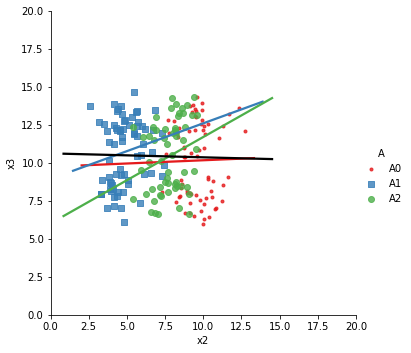

In [31]:
top_view = tuple(mix_rank_std[['attr1','attr2','groupbyAttr']].iloc[0])
sp_plot(many_sp_df_diff,*top_view)

THis ranks occurences, but we should also combine to rankthe views only, since that's what the actual figures will be. 

In [32]:

'_'.join([str(w) + c for c,w, in std_weights.items()])

'0.25reverseCorr_0.25angle_0.5portions'

In [33]:
list(std_weights.values())

[0.25, 0.25, 0.5]

In [34]:
result_df_colored_views[['angle','reverseCorr']] -result_df_colored_views[['angle','reverseCorr']].min()

,angle,reverseCorr
0,96.113681,0.031721
1,97.230178,0.021287
2,25.708176,0.968980
3,9.605124,1.107282
4,27.168283,0.969386
5,9.500169,1.129766
6,0.000000,1.201911
7,28.133999,1.007342
8,24.154579,1.039910
9,27.274139,0.989725
